In [1]:
import os
#spark imports
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
import csv

from pyspark.sql.types import *
from pyspark.sql.functions import format_number, when


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyspark.sql.functions as F
from sklearn.preprocessing import LabelEncoder

In [2]:
spark = SparkSession.builder.getOrCreate()

23/11/16 01:49:16 WARN Utils: Your hostname, praveens-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.5 instead (on interface en0)
23/11/16 01:49:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/16 01:49:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/16 01:49:17 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/11/16 01:49:17 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/11/16 01:49:32 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [3]:
# canalso get preprocessed data
data = pd.read_csv('2018onwards/part-00000-0d2974f4-155b-44d2-94f5-4d3f46536b61-c000.csv')
data = data.sample(n=50000)

In [4]:
data.drop(['Date'], axis=1)
data.columns


Index(['Date', 'Block', 'Primary Type', 'Location Description', 'Arrest',
       'Beat', 'District', 'Ward', 'Community Area', 'Year', 'Latitude',
       'Longitude', 'Day', 'Month', 'WeekDay'],
      dtype='object')

# Data Visualization

In [5]:
primaryVisualizeDF = data.groupby('Primary Type').size()

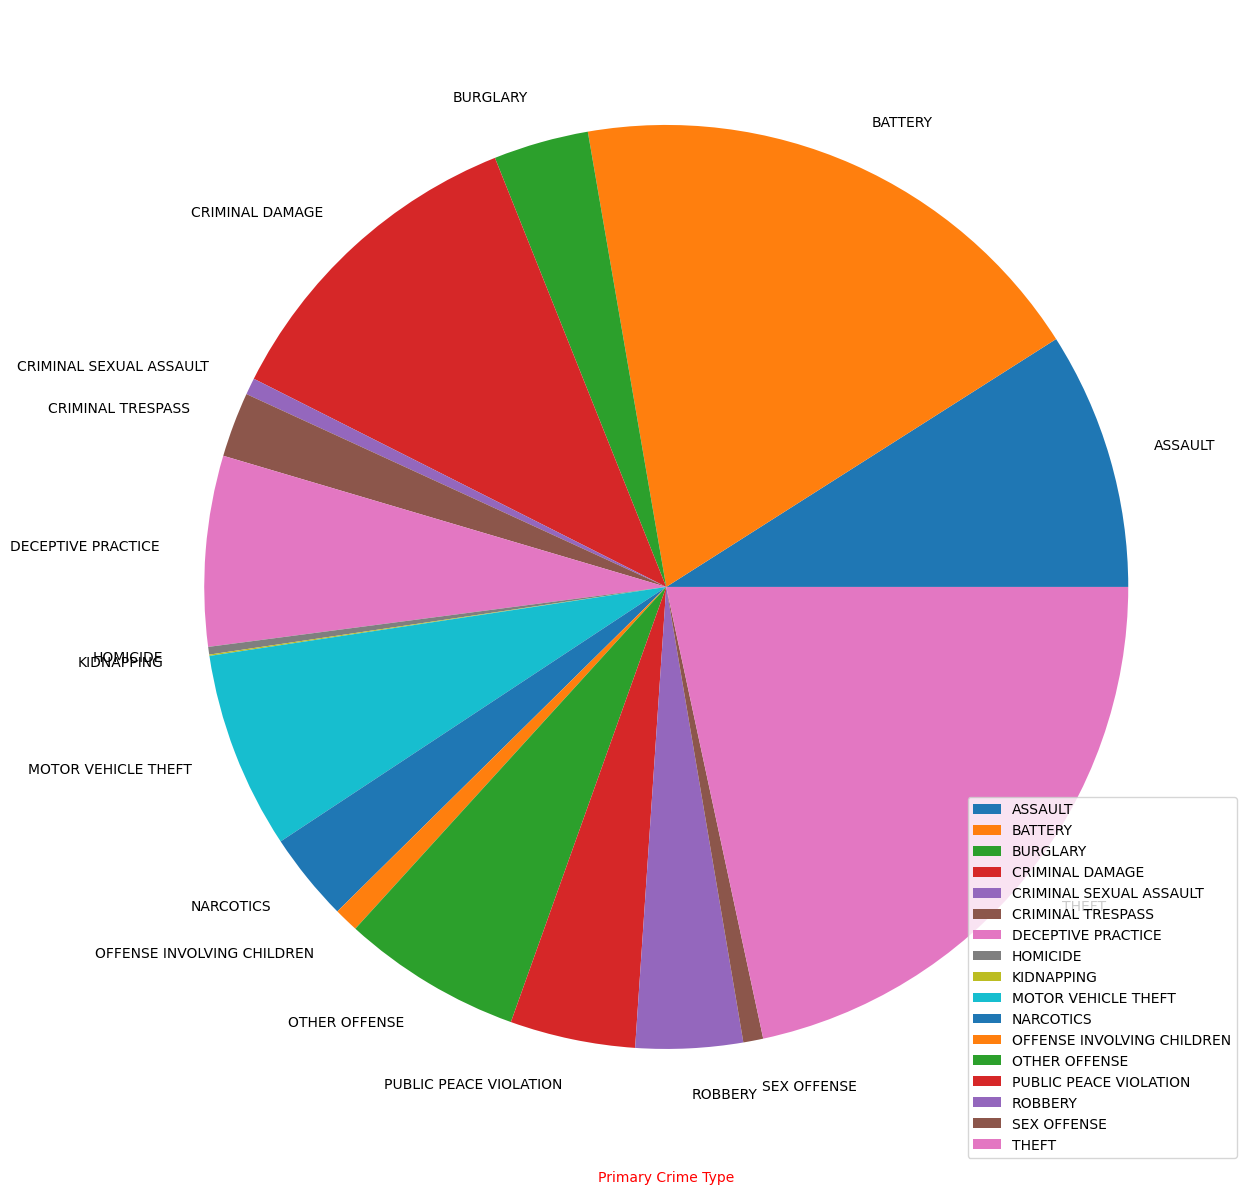

In [6]:
primaryVisualizeDF.plot.pie(figsize = (15,15))
plt.xlabel('Primary Crime Type', fontsize=10, color = 'red')
plt.legend()

# Preprocessing - specific to KNN model

In [7]:
data = data.replace(to_replace='None', value=np.nan).dropna()

**Label Encoding categorical variables**

In [8]:
# create an instance of label encoder for categorical variables
labelEncoder = LabelEncoder()

In [9]:
primaryEncoded = labelEncoder.fit_transform(data['Primary Type'])
primaryEncoded

array([ 3,  2,  2, ..., 10, 12, 12])

In [10]:
data['Primary Type'] = primaryEncoded

In [11]:
# create an instance of label encoder for categorical variables
labelEncoder2 = LabelEncoder()

In [12]:
locDiscEncoded = labelEncoder2.fit_transform(data['Location Description'])
locDiscEncoded

array([109, 106,  16, ..., 128,  92,  16])

In [13]:
data['Location Description'] = locDiscEncoded

In [14]:
# create an instance of label encoder for categorical variables
labelEncoder3 = LabelEncoder()

In [15]:
blockEncoded = labelEncoder2.fit_transform(data['Location Description'])
blockEncoded

array([109, 106,  16, ..., 128,  92,  16])

In [16]:
data['Block'] = locDiscEncoded

Use PCA to combine features

In [17]:
from sklearn.decomposition import PCA

In [18]:
location = data[['Latitude','Longitude']]
pca = PCA(n_components=1,random_state=123)

In [19]:
loc = pca.fit_transform(location)

In [20]:
data['Location'] = loc

In [21]:
data.head(5)

,Date,Block,Primary Type,Location Description,Arrest,Beat,District,Ward,Community Area,Year,Latitude,Longitude,Day,Month,WeekDay,Location
787999,06/24/2022 10:53:00 PM,109,3,109,False,1023,10,12,30,2022,41.854147,-87.694285,2022-06-24,6,6,-0.020392
831657,09/08/2022 11:00:00 PM,106,2,106,False,421,4,7,43,2022,41.756730,-87.562691,2022-09-08,9,5,0.126293
170453,02/22/2019 11:30:00 AM,16,2,16,False,1914,19,46,3,2019,41.969065,-87.656616,2019-02-22,2,6,-0.105515
920926,02/18/2023 02:00:00 PM,128,9,128,False,614,6,17,71,2023,41.746057,-87.671821,2023-02-18,2,7,0.086058
307934,08/18/2019 10:00:00 AM,16,1,16,True,422,4,7,46,2019,41.751951,-87.549962,2019-08-18,8,1,0.136347


# Feature selection

Checking importance of features using an ExtraTreesClassifier

In [22]:
# remove date coloum
#data = data.drop("Date", axis='columns')
data = data.drop("Day", axis='columns')
data = data.drop("Date", axis='columns')

In [23]:
#taking a fraction of data
data_sample = data.sample(frac=0.1, random_state=123)

In [24]:

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()

In [25]:

X = data_sample.loc[:, data.columns != 'Primary Type']

model.fit(X,data_sample['Primary Type'])

ExtraTreesClassifier()

In [26]:
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

[0.07224919 0.07187227 0.02578432 0.08335375 0.0376327  0.06549671
 0.06000858 0.07112556 0.10676826 0.11045144 0.09962024 0.08976776
 0.10586921]


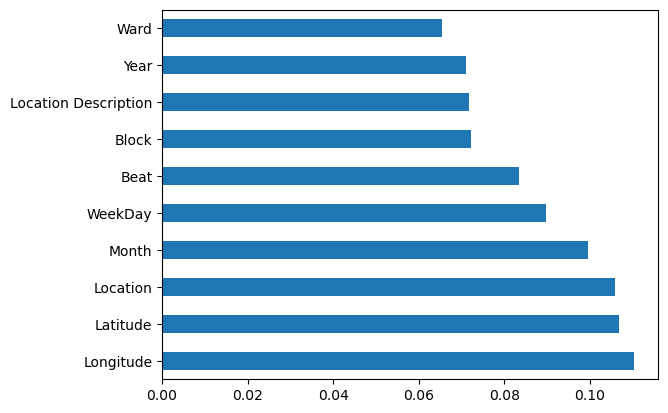

In [27]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
#plot for top 10 features
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Find corelation between data to find dependency between data columns

In [28]:
corelation = data.corr()
corelation

,Block,Primary Type,Location Description,Arrest,Beat,District,Ward,Community Area,Year,Latitude,Longitude,Month,WeekDay,Location
Block,1.000000,0.131553,1.000000,0.042358,0.009123,0.009471,-0.016424,0.030182,-0.026848,-0.055085,-0.007273,0.019896,0.000973,0.042882
Primary Type,0.131553,1.000000,0.131553,0.028579,0.044348,0.044324,0.062090,-0.090726,0.010091,0.093820,-0.000045,0.013278,0.011787,-0.076588
Location Description,1.000000,0.131553,1.000000,0.042358,0.009123,0.009471,-0.016424,0.030182,-0.026848,-0.055085,-0.007273,0.019896,0.000973,0.042882
Arrest,0.042358,0.028579,0.042358,1.000000,-0.015312,-0.015170,0.000726,0.011058,-0.101033,-0.014606,-0.035497,-0.041983,-0.011018,0.001783
Beat,0.009123,0.044348,0.009123,-0.015312,1.000000,0.999690,0.654673,-0.488773,0.005272,0.637856,-0.548287,0.003590,0.008812,-0.677200
District,0.009471,0.044324,0.009471,-0.015170,0.999690,1.000000,0.655758,-0.489481,0.005332,0.639138,-0.549384,0.003730,0.008687,-0.678560
Ward,-0.016424,0.062090,-0.016424,0.000726,0.654673,0.655758,1.000000,-0.523543,0.001349,0.679299,-0.475570,0.000116,0.001828,-0.690258
Community Area,0.030182,-0.090726,0.030182,0.011058,-0.488773,-0.489481,-0.523543,1.000000,-0.020357,-0.770438,0.235499,-0.005473,-0.007484,0.696082
Year,-0.026848,0.010091,-0.026848,-0.101033,0.005272,0.005332,0.001349,-0.020357,1.000000,0.020391,0.015052,-0.057236,-0.000748,-0.012344
Latitude,-0.055085,0.093820,-0.055085,-0.014606,0.637856,0.639138,0.679299,-0.770438,0.020391,1.000000,-0.541116,0.005379,0.004901,-0.970731


<Axes: >

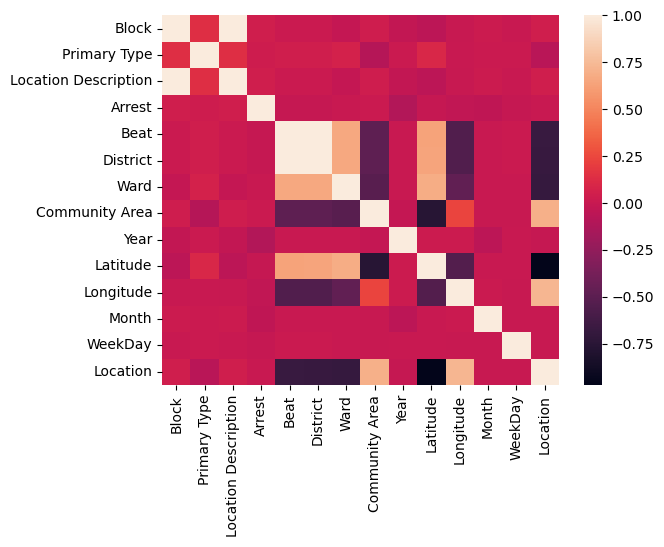

In [29]:
import seaborn as sns
sns.heatmap(corelation)

**Based on the above outputs, we have decided that below selected columns are corelated and best params for our KNN model**

In [30]:
selected_columns = ['Latitude','Longitude','Location Description','Block','WeekDay']
#selected_columns = ['Latitude','Longitude']

# Splitting data in train and test

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[selected_columns], data['Primary Type'], test_size=0.3) # 70% training and 30% test

# Building initial KNN Classifier

**Initially we will build our classifier with 5 neighbours**

In [32]:
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
knn_5 = KNeighborsClassifier(n_neighbors=5) 
knn_5.fit(X_train,y_train)
pred_train = knn_5.predict(X_train)
pred_i = knn_5.predict(X_test)
print('Test accuracy ', metrics.accuracy_score(y_train, pred_train))
print('Accuracy ', metrics.accuracy_score(y_test, pred_i))
print('F1 score ', metrics.f1_score(y_test, pred_i, average = 'weighted'))

Test accuracy  0.4529714285714286
Accuracy  0.24173333333333333
F1 score  0.2304891506515162


We will deploy Elbow method to get optimum number of neighbours

In [33]:
error_rate = []

krange = range(10,50,5)
for i in krange:
 
 knn = KNeighborsClassifier(n_neighbors=i, metric='manhattan', weights = 'uniform',n_jobs= -1) # haversine - if only lat long
 knn.fit(X_train,y_train)
 pred_train = knn.predict(X_train)
 pred_i = knn.predict(X_test)
 error_rate.append(np.mean(pred_i != y_test))
 print('Neighbours ',i)
 print('Test accuracy ', metrics.accuracy_score(y_train, pred_train))
 print('Accuracy ', metrics.accuracy_score(y_test, pred_i))
 print('F1 score ', metrics.f1_score(y_test, pred_i, average = 'weighted'))

Neighbours  10
Test accuracy  0.39225714285714286
Accuracy  0.26813333333333333
F1 score  0.24458029915969753
Neighbours  15
Test accuracy  0.36682857142857145
Accuracy  0.2806
F1 score  0.25048992737150555
Neighbours  20
Test accuracy  0.35491428571428574
Accuracy  0.28833333333333333
F1 score  0.25218613176583515
Neighbours  25
Test accuracy  0.3447142857142857
Accuracy  0.2934
F1 score  0.2508253435512961
Neighbours  30
Test accuracy  0.3376857142857143
Accuracy  0.294
F1 score  0.24754105559585501
Neighbours  35
Test accuracy  0.33414285714285713
Accuracy  0.29433333333333334
F1 score  0.2457501684616552
Neighbours  40
Test accuracy  0.3318285714285714
Accuracy  0.2981333333333333
F1 score  0.2480858547934564
Neighbours  45
Test accuracy  0.3292
Accuracy  0.2982666666666667
F1 score  0.2467167680490472


Text(0, 0.5, 'Error Rate')

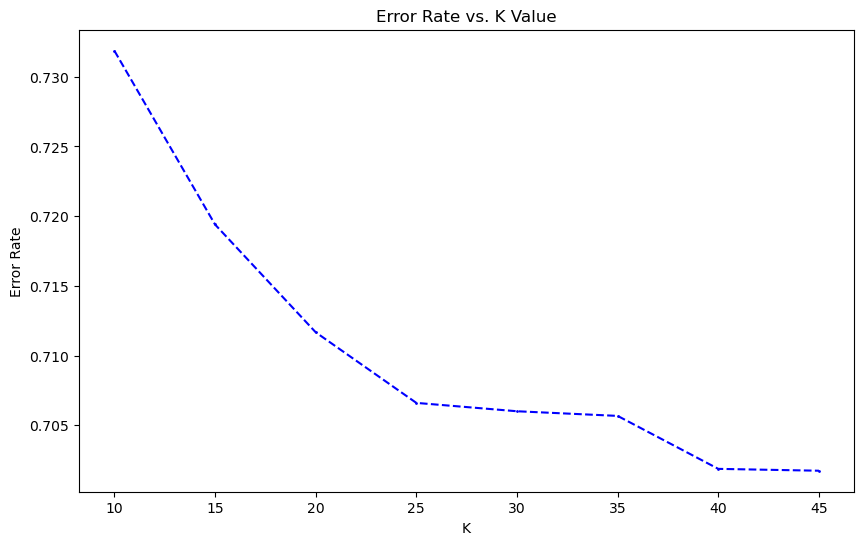

In [34]:
plt.figure(figsize=(10,6))

plt.plot(krange,error_rate, color= 'blue', linestyle= 'dashed', marker= 'o', markerfacecolor='red', markersize=1)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

K = 25, optimum

# Grid Search/ Random Search -KNN

**To find optimal paramteres for KNN Model, we will implement Grid search.**

In [35]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [36]:
KNeighborsClassifier().get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [37]:
grid_params = {
    'weights' : ['uniform', 'distance'],
    'metric' : ['manhattan','jaccard'] #haversine - if only lat long
}

In [38]:
randomSearch = RandomizedSearchCV(
    KNeighborsClassifier(35),
    grid_params,
    verbose = 1,
    cv =3,
    random_state = 123
    )


In [39]:
#takes very long time
rs_results = randomSearch.fit(X_train, y_train)

/Users/praveen/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [40]:
rs_results.best_score_

0.2934001572182065

In [41]:
rs_results.best_params_

{'weights': 'uniform', 'metric': 'manhattan'}